In [95]:
# !pip install -U spacy
# !python3 -m spacy download en_core_web_sm
#! pip install wordcloud

  Using cached wordcloud-1.8.0-cp37-cp37m-manylinux1_x86_64.whl (365 kB)


In [96]:
# core libraries
import re
import time
import string

# data handling and machine learning
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# text processing
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')  # 'en'
stopwords = set(en_stopwords + ['jay'])  # I have tried different common words but decided not to
from wordcloud import WordCloud

# plotting
import matplotlib.pyplot as plt
%matplotlib inline



In [13]:
import os
os.getcwd()

'/root'

In [14]:
raw_data = pd.read_csv('/root/MSDS682/df_location_master_final.csv', sep = ',' , parse_dates=True)  

In [15]:
raw_data.columns=raw_data.columns.str.replace(' ', '_')
raw_data.columns=map(str.lower, raw_data.columns)
print(raw_data.columns)

Index(['unnamed:_0', 'business_id', 'business_name', 'business_address',
       'business_city', 'business_state', 'business_postal_code',
       'business_latitude', 'business_longitude', 'neighborhood',
       'inspection_id', 'inspection_date', 'inspection_score',
       'inspection_type', 'violation_id', 'violation_description',
       'risk_category'],
      dtype='object')


In [43]:
df_corpus=raw_data[['business_id','inspection_date', 'violation_description']]
df_corpus['inspection_date']= pd.to_datetime(df_corpus['inspection_date'])

df_corpus['violation_description'] = df_corpus['violation_description'].fillna('noviolation')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [45]:
df_corpus.head(5)
# Do I add No violation as a text? I have done both ways and decided to do noviolation a single word. This way i will get the benefit of having it without the effect of seperate No .exactly what I wanted and feel works th ebest this way
# So I need to addNoViolation to Nans. I did!!!

,business_id,inspection_date,violation_description
0,852,2017-11-29,Improper food storage
1,852,2017-11-29,Permit license or inspection report not posted
2,852,2017-11-29,Unapproved or unmaintained equipment or utensils
3,852,2017-12-07,noviolation
4,852,2017-11-29,Wiping cloths not clean or properly stored or ...


In [ ]:
df_corpus['violation_description']= df_corpus['violation_description'].to_string() 

# Time series

In [122]:
df_corpusv2=df_corpus[['inspection_date', 'violation_description']]

In [123]:
df_corpusv2.head()

,inspection_date,violation_description
0,2017-11-29,Improper food storage
1,2017-11-29,Permit license or inspection report not posted
2,2017-11-29,Unapproved or unmaintained equipment or utensils
3,2017-12-07,noviolation
4,2017-11-29,Wiping cloths not clean or properly stored or ...


In [124]:
#load headline_text to reindexed_data
reindexed_data = df_corpusv2['violation_description']
reindexed_data

0                                    Improper food storage
1           Permit license or inspection report not posted
2         Unapproved or unmaintained equipment or utensils
3                                              noviolation
4        Wiping cloths not clean or properly stored or ...
                               ...                        
48760                             Improper thawing methods
48761               Moderate risk food holding temperature
48762                                Improper food storage
48763    Inadequate dressing rooms or improper storage ...
48764                                          noviolation
Name: violation_description, Length: 48765, dtype: object

In [125]:
#load publish_date to reindexed_data.index as a list
reindexed_data.index = df_corpusv2['inspection_date']
reindexed_data.index

DatetimeIndex(['2017-11-29', '2017-11-29', '2017-11-29', '2017-12-07',
               '2017-11-29', '2017-11-29', '2017-11-29', '2018-08-16',
               '2018-03-30', '2018-08-31',
               ...
               '2016-10-28', '2019-02-20', '2017-12-13', '2017-12-13',
               '2017-11-21', '2017-11-21', '2017-11-21', '2017-11-21',
               '2017-11-21', '2017-12-04'],
              dtype='datetime64[ns]', name='inspection_date', length=48765, freq=None)

In [126]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

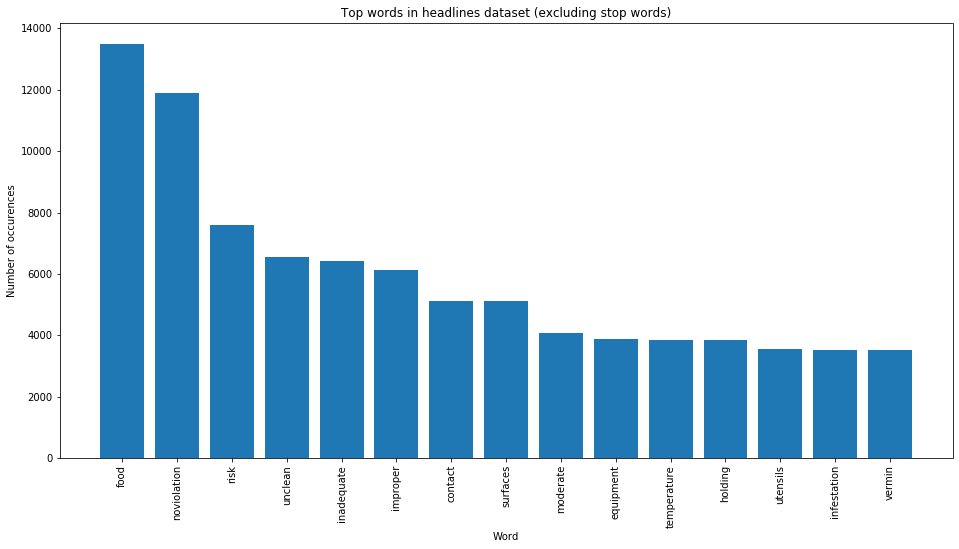

In [127]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

### Daily, Monthly and Yearly distribution of the words!
#### Plotting the number of violations posted per day, per month and per year to get a sense of the sample density.
#### There is a significant increase from 2017 to 2018. I think just like any time series data, this analysis can benefit from more observations.

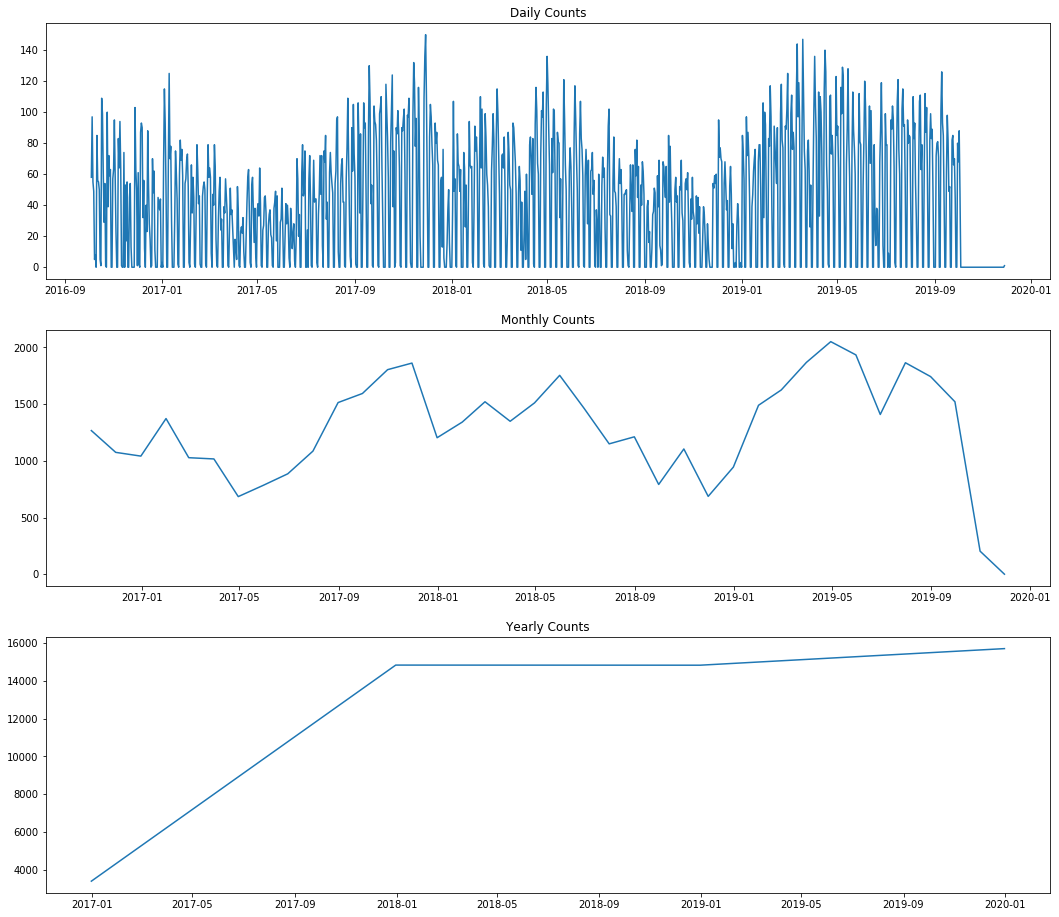

In [129]:
monthly_counts = reindexed_data.resample('M').count()
yearly_counts = reindexed_data.resample('A').count()
daily_counts = reindexed_data.resample('D').count()

fig, ax = plt.subplots(3, figsize=(18,16))
ax[0].plot(daily_counts);
ax[0].set_title('Daily Counts');
ax[1].plot(monthly_counts);
ax[1].set_title('Monthly Counts');
ax[2].plot(yearly_counts);
ax[2].set_title('Yearly Counts');
plt.show()